# **Libraries**

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from PIL import Image

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

from sklearn.utils.class_weight import compute_sample_weight

import xgboost as xgb
import gradio as gr
import joblib


# **Pre-Processing**

In [18]:
train = pd.read_csv('/content/fashion-mnist_train.csv')
test = pd.read_csv('/content/fashion-mnist_test.csv')

In [19]:
train

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
f'train shape {train.shape}', f'test shape {test.shape}'

('train shape (60000, 785)', 'test shape (10000, 785)')

In [21]:
sum(train.isna().sum())
sum(test.isna().sum())

0

In [22]:
print(train.duplicated().sum(),test.duplicated().sum())



43 1


In [23]:
train.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)

In [24]:
train['label'].value_counts()


,count
label,
5,6000
8,6000
0,5998
9,5998
3,5997
7,5996
1,5996
4,5995
6,5989


# **EDA**

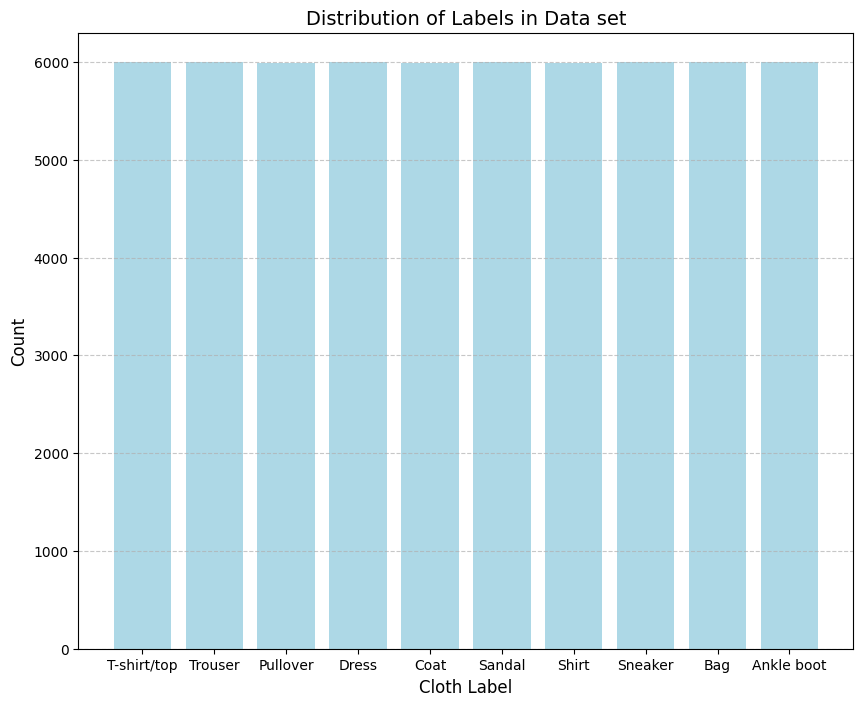

In [25]:
label_counts = train['label'].value_counts().sort_index()

plt.figure(figsize=(10, 8))
plt.bar(label_counts.index, label_counts.values, color='lightblue')
plt.title('Distribution of Labels in Data set', fontsize=14)
plt.xlabel('Cloth Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(ticks=range(10), labels=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

In [26]:
X_train = train.drop('label', axis=1)
y_train = train['label']
X_test = test.drop('label', axis=1)
y_test = test['label']

In [27]:
# Step 1: Normalize pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0


In [28]:
print("Min Pixel Value:", X_train.iloc[:, 1:].min().min())
print("Max Pixel Value:", X_train.iloc[:, 1:].max().max())

Min Pixel Value: 0.0
Max Pixel Value: 1.0


In [29]:
def show_images(n, dataset=X_train,  MAX_IMGS=300):
    num_cols = 10
    if n % num_cols == 0 and n <= MAX_IMGS:
        images = dataset.iloc[:n].values.reshape(-1, 28, 28)
        num_rows = n // num_cols
        fig, ax = plt.subplots(num_rows, num_cols, figsize=(num_cols, num_rows))
        for i in range(num_rows):
            for j in range(num_cols):
                ax[i, j].imshow(images[i * num_cols + j], cmap='gray')
                ax[i, j].axis('off')
        plt.show()
    else:
        print('Invalid images')

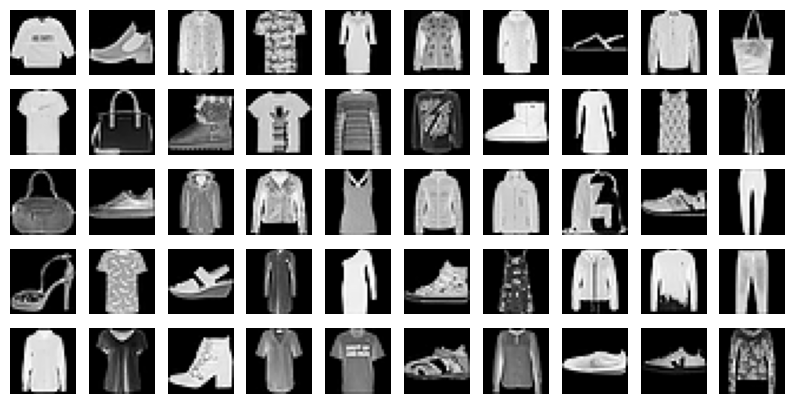

In [30]:
show_images(50)


In [31]:
def show_type(type, dataset=X_train):
    if type in range(10):
        digit_indices = np.where(y_train == type)[0]

        for i in range(50):  # Display the first 50 images of the digit
            plt.subplot(5, 10, i + 1)
            imdata = dataset.iloc[digit_indices[i]].values.reshape(28, 28)
            plt.imshow(imdata, cmap='gray')
            plt.xticks([])
            plt.yticks([])

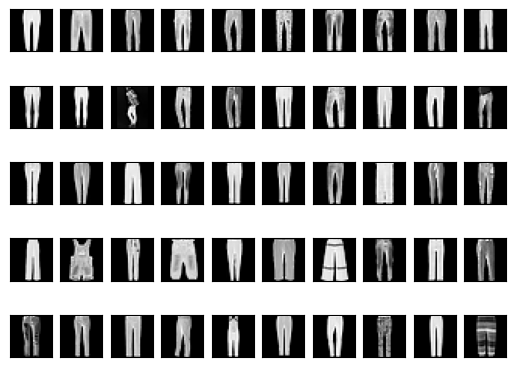

In [32]:
show_type(1)


# **Random Forest**

In [ ]:

# Grid of hyperparameters
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize classifier
rf = RandomForestClassifier(random_state=42)

# Set up grid search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Train
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [ ]:
# Use best model
best_rf = grid_search.best_estimator_

# Predict on test data
y_pred = best_rf.predict(X_test)

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.8818881888188819
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       999
           1       0.99      0.97      0.98      1000
           2       0.81      0.81      0.81      1000
           3       0.89      0.93      0.91      1000
           4       0.80      0.86      0.83      1000
           5       0.97      0.95      0.96      1000
           6       0.73      0.61      0.67      1000
           7       0.92      0.93      0.92      1000
           8       0.95      0.97      0.96      1000
           9       0.93      0.95      0.94      1000

    accuracy                           0.88      9999
   macro avg       0.88      0.88      0.88      9999
weighted avg       0.88      0.88      0.88      9999



# **XGboost**

In [ ]:
pip install xgboost


In [ ]:

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Initialize XGBoost model
xgb_clf = xgb.XGBClassifier(
    objective='multi:softmax',     # Multiclass classification
    num_class=10,                  # 10 classes in Fashion-MNIST
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='mlogloss',
    verbosity=1,
    random_state=42
)

# Fit to full training data
xgb_clf.fit(X_train, y_train, sample_weight=sample_weights)

# Predict
y_pred = xgb_clf.predict(X_test)

# Evaluate
print("Accuracy (XGBoost):", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:10:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy (XGBoost): 0.8983898389838983
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       999
           1       0.99      0.98      0.99      1000
           2       0.83      0.81      0.82      1000
           3       0.91      0.92      0.92      1000
           4       0.83      0.86      0.85      1000
           5       0.99      0.95      0.97      1000
           6       0.74      0.70      0.72      1000
           7       0.94      0.95      0.95      1000
           8       0.97      0.98      0.97      1000
           9       0.95      0.96      0.95      1000

    accuracy                           0.90      9999
   macro avg       0.90      0.90      0.90      9999
weighted avg       0.90      0.90      0.90      9999



# ***Model Comparison***

In [ ]:

# Predictions
rf_preds = best_rf.predict(X_test)
xgb_preds = xgb_clf.predict(X_test)

# Accuracy
rf_acc = accuracy_score(y_test, rf_preds)
xgb_acc = accuracy_score(y_test, xgb_preds)

print(f"Random Forest Accuracy: {rf_acc:.4f}")
print(f"XGBoost Accuracy: {xgb_acc:.4f}")


Random Forest Accuracy: 0.8819
XGBoost Accuracy: 0.8984


/tmp/ipython-input-22-3813561166.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='Set2')


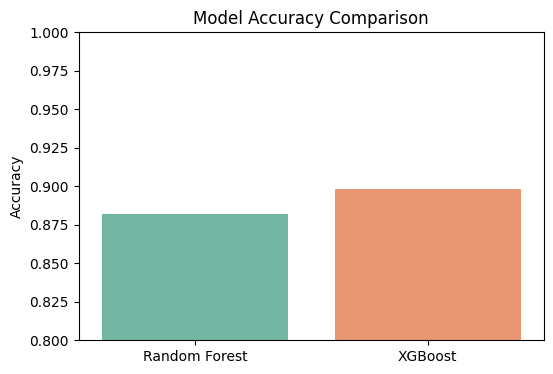

In [ ]:
models = ['Random Forest', 'XGBoost']
accuracies = [rf_acc, xgb_acc]

plt.figure(figsize=(6, 4))
sns.barplot(x=models, y=accuracies, palette='Set2')
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0.8, 1)
plt.show()


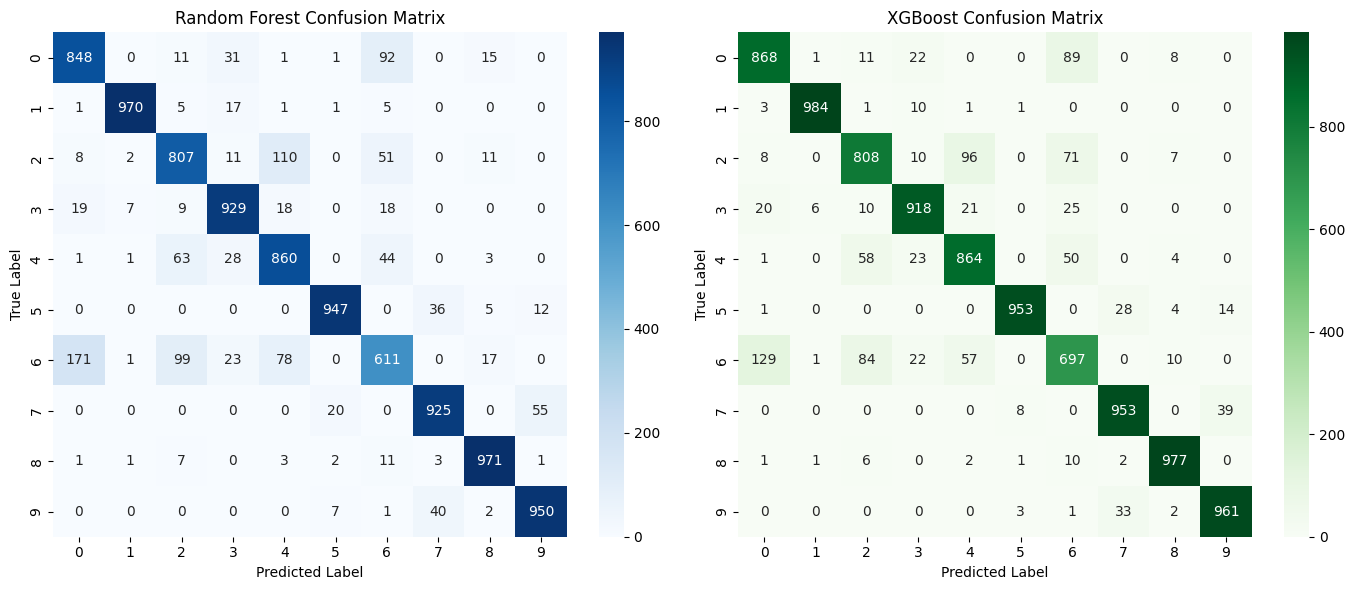

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest Confusion Matrix
sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Random Forest Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# XGBoost Confusion Matrix
sns.heatmap(confusion_matrix(y_test, xgb_preds), annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title("XGBoost Confusion Matrix")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()


In [ ]:


# Predictions
rf_train_preds = best_rf.predict(X_train)
rf_test_preds = best_rf.predict(X_test)

xgb_train_preds = xgb_clf.predict(X_train)
xgb_test_preds = xgb_clf.predict(X_test)

# Accuracies
rf_train_acc = accuracy_score(y_train, rf_train_preds)
rf_test_acc = accuracy_score(y_test, rf_test_preds)

xgb_train_acc = accuracy_score(y_train, xgb_train_preds)
xgb_test_acc = accuracy_score(y_test, xgb_test_preds)

# Print results
print("Random Forest - Train Accuracy:", round(rf_train_acc, 4))
print("Random Forest - Test Accuracy :", round(rf_test_acc, 4))
print()
print("XGBoost       - Train Accuracy:", round(xgb_train_acc, 4))
print("XGBoost       - Test Accuracy :", round(xgb_test_acc, 4))


Random Forest - Train Accuracy: 0.9989
Random Forest - Test Accuracy : 0.8819

XGBoost       - Train Accuracy: 0.9595
XGBoost       - Test Accuracy : 0.8984


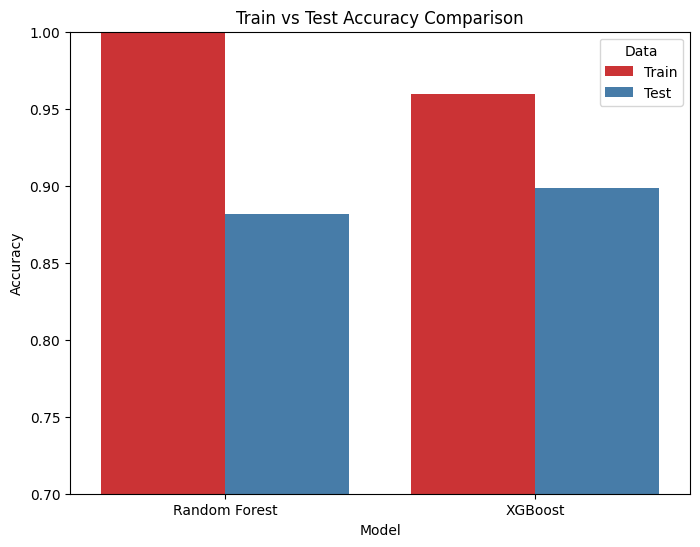

In [ ]:

# Data for plotting
model_names = ['Random Forest', 'Random Forest', 'XGBoost', 'XGBoost']
data_type = ['Train', 'Test', 'Train', 'Test']
accuracy_values = [rf_train_acc, rf_test_acc, xgb_train_acc, xgb_test_acc]

# Create a DataFrame for easier plotting
import pandas as pd
df_plot = pd.DataFrame({
    'Model': model_names,
    'Data': data_type,
    'Accuracy': accuracy_values
})

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Accuracy', hue='Data', data=df_plot, palette='Set1')
plt.title('Train vs Test Accuracy Comparison')
plt.ylim(0.7, 1.0)
plt.ylabel('Accuracy')
plt.show()


In [ ]:

joblib.dump(xgb_clf, 'xgboost_model.pkl')


['rf_model.pkl']

# **Deployment with gradio**

In [33]:

!pip install gradio --quiet



In [34]:

# Load the trained model
model = joblib.load("xgboost_model.pkl")

# Define your class labels (Fashion-MNIST assumed)
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Preprocess image to match training format
def preprocess_image(image):
    image = image.convert("L")            # Convert to grayscale
    image = image.resize((28, 28))        # Resize to 28x28
    image_array = np.array(image) / 255.0 # Normalize pixel values
    image_array = image_array.flatten()   # Flatten to 1D (784,)
    return image_array.reshape(1, -1)     # Reshape for prediction

# Prediction function
def predict_image(img):
    processed = preprocess_image(img)
    prediction = model.predict(processed)[0]
    return class_names[int(prediction)]

# Create Gradio interface
demo = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil", label="Upload Fashion Image"),
    outputs=gr.Label(num_top_classes=1),
    title="Fashion-MNIST XGBoost Classifier",
    description="Upload a 28x28 grayscale image of a clothing item for prediction."
)

# Launch the app
demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a220f0b92b1f8ae342.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
